In [1]:
from __future__ import division

import os
import operator
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle

from utils import *
from skimage import transform 
from tqdm import tqdm, tqdm_notebook
from keras import initializers

from keras.layers import Input
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

# Amund stuff
from keras.layers.core import Reshape,Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist


from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam

# share GPU
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
set_session(tf.Session(config=config))

%matplotlib inline

Using TensorFlow backend.


In [2]:
# data constants
max_size = (32, 32, 1)
data_files = {'cifar': '../data/cifar.npy',
              'mnist': '../data/mnist.npy',
              'lfw': '../data/lfw.npy'}

# load and transform data
data = np.load(data_files['mnist'])
data = data.astype('float32')

if data.shape[1:3] > max_size:
    data = np.array([transform.resize(image, max_size, preserve_range=True, order=0)] 
                    for image in data)

# shuffle data
np.random.shuffle(data)

# get data sizes
data_count = data.shape[0]
data_size = data.shape[1:4] if data.shape[3] > 1 else data.shape[1:3]
data_dim = reduce(operator.mul, data.shape[1:])

# reshape data if necessary
data = data.reshape(data_count, *data_size)

print 'Loaded data {}'.format(data.shape)

Loaded data (70000, 28, 28)


In [3]:
data_reshaped = data.reshape(data_count, -1)
data_mean = np.mean(data_reshaped, axis=1, keepdims=True, dtype=np.float64)
data_z_mean = (data_reshaped - data_mean)
data_std = np.std(data_z_mean, axis=1, keepdims=True, dtype=np.float64) + 1e-16
data_normed = data_z_mean / data_std
data_proc = data_normed.reshape(data_count, *data_size)

print 'Before preproc', data.mean(), data.std()
print 'After preproc', data_proc.mean(), data_proc.std()

Before preproc 33.3859 78.6544
After preproc 1.56143319848e-19 1.0


In [4]:
# latent space generators
def get_uniform_space(high, low, space_size):
    return lambda batch_size: np.random.uniform(low, high, (batch_size, space_size)).astype('float32')

def get_gaussian_space(mean, var, space_size):
    return lambda batch_size: np.random.normal(mean, var, (batch_size, space_size)).astype('float32')

In [5]:
def get_mlp_model(data_dim, latent_dim):
    # setup optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)

    leaky_alpha = 0.0
    dropout_p = 0.3
    # setup generator network
    #generator = Sequential()
    #generator.add(Dense(256, input_dim=latent_dim, kernel_initializer='random_normal'))
    #generator.add(LeakyReLU(alpha=leaky_alpha))
    #generator.add(Dense(512))
    #generator.add(LeakyReLU(alpha=leaky_alpha))
    #generator.add(Dense(1024))
    #generator.add(LeakyReLU(alpha=leaky_alpha))
    #generator.add(Dense(data_dim, activation='tanh'))
    #generator.compile(loss='binary_crossentropy', optimizer=opt)

    # setup discriminator network
    #discriminator = Sequential()
    #discriminator.add(Dense(1024, input_dim=data_dim, kernel_initializer='random_normal'))
    #discriminator.add(LeakyReLU(alpha=leaky_alpha))
    #discriminator.add(Dense(512))
    #discriminator.add(LeakyReLU(alpha=leaky_alpha))
    #discriminator.add(Dense(256))
    #discriminator.add(LeakyReLU(alpha=leaky_alpha))
    #discriminator.add(Dense(1, activation='sigmoid'))
    #discriminator.compile(loss='binary_crossentropy', optimizer=opt)
    
    # Function for initializing network weights

    # Optimizer
    adam = Adam(lr=0.0002, beta_1=0.5)

    # Generator
    generator = Sequential()
    generator.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer='random_normal'))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((7,7,128)))
    generator.add(UpSampling2D(size=(2, 2)))#1
    generator.add(Conv2D(filters=64,kernel_size=(5,5), padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2,2)))
    generator.add(Conv2D(filters=1,kernel_size=(5,5), padding='same', activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=adam)

    # Discriminator
    discriminator = Sequential()
    discriminator.add(Conv2D(filters=64,kernel_size=(5,5),
                             padding='same', strides=(2,2), 
                             input_shape=(28,28,1), 
                             kernel_initializer='random_normal'))
    discriminator.add(LeakyReLU(0.2))
    #discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(filters=128,kernel_size=(5,5), padding='same', strides=(2,2)))
    discriminator.add(LeakyReLU(0.2))
    #discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=adam)

    from pdb import set_trace as trace
    
        
    # setup combined network
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return (generator, discriminator, gan)

100%|██████████| 546/546 [00:47<00:00, 11.50it/s]


epoch: 0 -- loss G: 3.93686699867 - D: 0.187896475196


100%|██████████| 546/546 [00:45<00:00, 11.92it/s]


epoch: 1 -- loss G: 5.46746683121 - D: 0.176545202732


100%|██████████| 546/546 [00:45<00:00, 11.88it/s]


epoch: 2 -- loss G: 5.72968769073 - D: 0.177313357592


100%|██████████| 546/546 [00:45<00:00, 11.92it/s]


epoch: 3 -- loss G: 5.91110801697 - D: 0.173103660345


100%|██████████| 546/546 [00:45<00:00, 11.93it/s]


epoch: 4 -- loss G: 6.13569307327 - D: 0.171009913087


100%|██████████| 546/546 [00:45<00:00, 11.87it/s]


epoch: 5 -- loss G: 6.41841888428 - D: 0.170480310917


100%|██████████| 546/546 [00:45<00:00, 11.83it/s]


epoch: 6 -- loss G: 5.73895931244 - D: 0.16824182868


100%|██████████| 546/546 [00:45<00:00, 11.89it/s]


epoch: 7 -- loss G: 5.95794773102 - D: 0.167528063059


100%|██████████| 546/546 [00:45<00:00, 11.90it/s]


epoch: 8 -- loss G: 6.16226816177 - D: 0.166909322143


100%|██████████| 546/546 [00:45<00:00, 11.90it/s]


epoch: 9 -- loss G: 6.32308769226 - D: 0.166591599584


100%|██████████| 546/546 [00:45<00:00, 11.90it/s]


epoch: 10 -- loss G: 7.40555858612 - D: 0.163570731878


100%|██████████| 546/546 [00:45<00:00, 11.93it/s]


epoch: 11 -- loss G: 6.71691036224 - D: 0.165120005608


100%|██████████| 546/546 [00:45<00:00, 11.92it/s]


epoch: 12 -- loss G: 8.04341316223 - D: 0.163185417652


100%|██████████| 546/546 [00:45<00:00, 11.85it/s]


epoch: 13 -- loss G: 6.98731994629 - D: 0.165228784084


100%|██████████| 546/546 [00:45<00:00, 11.88it/s]


epoch: 14 -- loss G: 8.58170604706 - D: 0.165160015225


100%|██████████| 546/546 [00:45<00:00, 11.88it/s]


epoch: 15 -- loss G: 7.35272216797 - D: 0.164399206638


100%|██████████| 546/546 [00:45<00:00, 11.88it/s]


epoch: 16 -- loss G: 7.47332286835 - D: 0.165410131216


100%|██████████| 546/546 [00:45<00:00, 11.83it/s]


epoch: 17 -- loss G: 7.04172992706 - D: 0.163707002997


100%|██████████| 546/546 [00:45<00:00, 11.85it/s]


epoch: 18 -- loss G: 8.11969184875 - D: 0.163111492991


100%|██████████| 546/546 [00:45<00:00, 11.89it/s]


epoch: 19 -- loss G: 8.69090080261 - D: 0.162897005677


100%|██████████| 546/546 [00:45<00:00, 11.84it/s]
/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch: 20 -- loss G: 8.30577659607 - D: 0.163687422872


100%|██████████| 546/546 [00:45<00:00, 11.95it/s]


epoch: 21 -- loss G: 8.80072975159 - D: 0.162857115269


100%|██████████| 546/546 [00:45<00:00, 11.96it/s]


epoch: 22 -- loss G: 7.85968923569 - D: 0.163159370422


100%|██████████| 546/546 [00:45<00:00, 11.99it/s]


epoch: 23 -- loss G: 8.89543151855 - D: 0.162888392806


100%|██████████| 546/546 [00:45<00:00, 11.93it/s]


epoch: 24 -- loss G: 8.92107009888 - D: 0.162956252694


100%|██████████| 546/546 [00:46<00:00, 11.92it/s]


epoch: 25 -- loss G: 9.0527715683 - D: 0.162802532315


100%|██████████| 546/546 [00:45<00:00, 11.88it/s]


epoch: 26 -- loss G: 9.26802253723 - D: 0.162775099277


100%|██████████| 546/546 [00:45<00:00, 11.91it/s]


epoch: 27 -- loss G: 9.45599937439 - D: 0.163108274341


100%|██████████| 546/546 [00:45<00:00, 11.86it/s]


epoch: 28 -- loss G: 9.68156719208 - D: 0.163920342922


100%|██████████| 546/546 [00:45<00:00, 11.90it/s]


epoch: 29 -- loss G: 6.84286928177 - D: 0.163971498609


100%|██████████| 546/546 [00:45<00:00, 11.86it/s]


epoch: 30 -- loss G: 8.84451675415 - D: 0.162975862622


100%|██████████| 546/546 [00:45<00:00, 11.90it/s]


epoch: 31 -- loss G: 9.27353572845 - D: 0.162790551782


100%|██████████| 546/546 [00:45<00:00, 11.87it/s]


epoch: 32 -- loss G: 9.13397884369 - D: 0.16285571456


100%|██████████| 546/546 [00:45<00:00, 11.98it/s]


epoch: 33 -- loss G: 9.6551027298 - D: 0.162720784545


100%|██████████| 546/546 [00:45<00:00, 11.95it/s]


epoch: 34 -- loss G: 9.479139328 - D: 0.162785261869


100%|██████████| 546/546 [00:45<00:00, 11.92it/s]


epoch: 35 -- loss G: 8.99407100677 - D: 0.163551241159


100%|██████████| 546/546 [00:45<00:00, 11.89it/s]


epoch: 36 -- loss G: 9.65205478668 - D: 0.162872761488


100%|██████████| 546/546 [00:45<00:00, 11.96it/s]


epoch: 37 -- loss G: 7.9527797699 - D: 0.163042381406


100%|██████████| 546/546 [00:45<00:00, 11.97it/s]


epoch: 38 -- loss G: 9.20468521118 - D: 0.162759453058


100%|██████████| 546/546 [00:45<00:00, 11.90it/s]


epoch: 39 -- loss G: 9.46371650696 - D: 0.162820577621


100%|██████████| 546/546 [00:45<00:00, 11.96it/s]


epoch: 40 -- loss G: 9.91655921936 - D: 0.162695556879


100%|██████████| 546/546 [00:45<00:00, 11.98it/s]


epoch: 41 -- loss G: 10.0808620453 - D: 0.162664815784


100%|██████████| 546/546 [00:45<00:00, 11.98it/s]


epoch: 42 -- loss G: 10.1118936539 - D: 0.162709265947


100%|██████████| 546/546 [00:45<00:00, 11.96it/s]


epoch: 43 -- loss G: 9.40711402893 - D: 0.162775620818


100%|██████████| 546/546 [00:45<00:00, 12.02it/s]


epoch: 44 -- loss G: 9.01338005066 - D: 0.162829592824


100%|██████████| 546/546 [00:45<00:00, 11.95it/s]


epoch: 45 -- loss G: 9.96849632263 - D: 0.162730962038


100%|██████████| 546/546 [00:45<00:00, 11.95it/s]


epoch: 46 -- loss G: 10.1657810211 - D: 0.162667885423


100%|██████████| 546/546 [00:45<00:00, 11.99it/s]


epoch: 47 -- loss G: 9.07368946075 - D: 0.162742227316


100%|██████████| 546/546 [00:45<00:00, 12.00it/s]


epoch: 48 -- loss G: 9.94795227051 - D: 0.162681564689


100%|██████████| 546/546 [00:45<00:00, 11.91it/s]


epoch: 49 -- loss G: 9.97421455383 - D: 0.162706792355


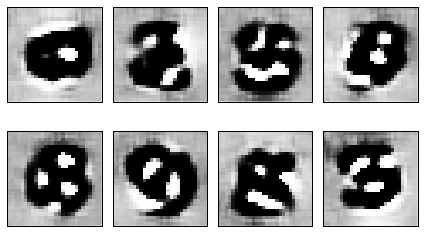

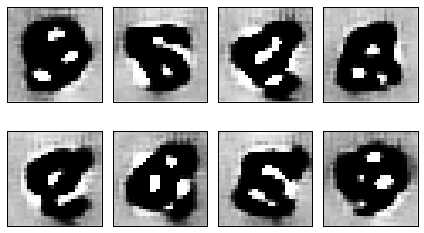

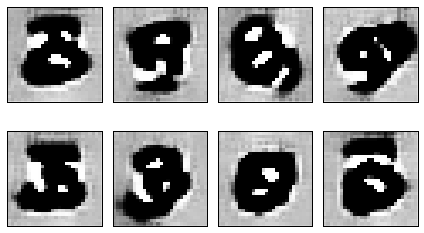

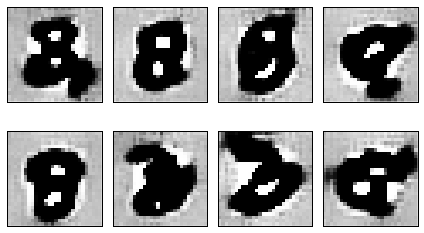

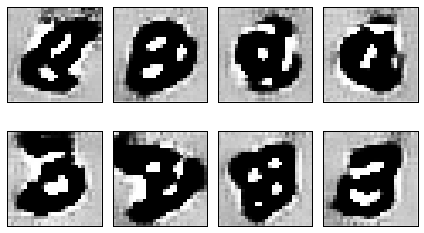

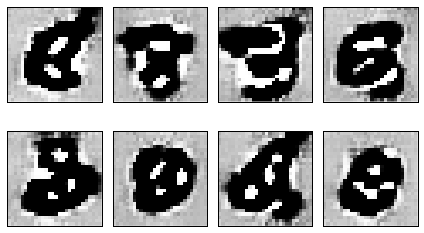

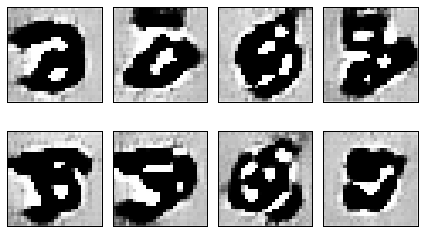

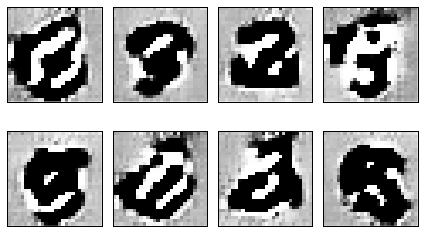

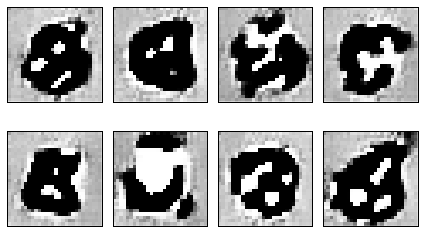

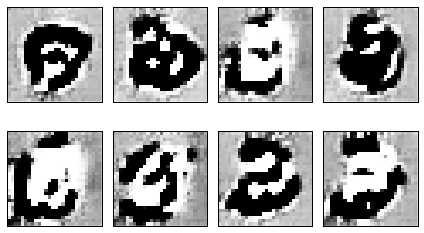

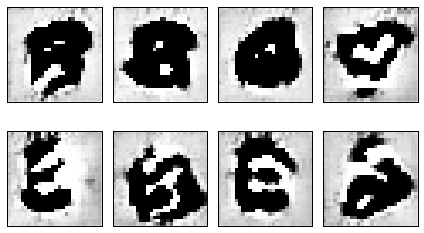

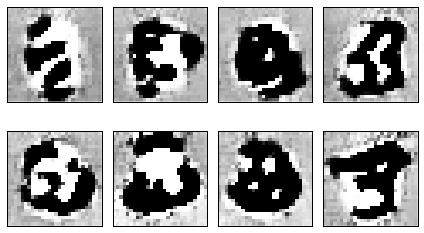

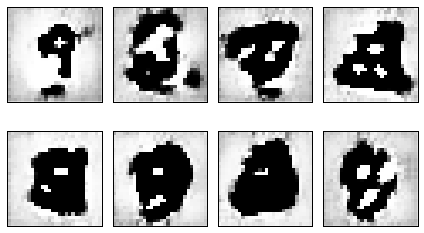

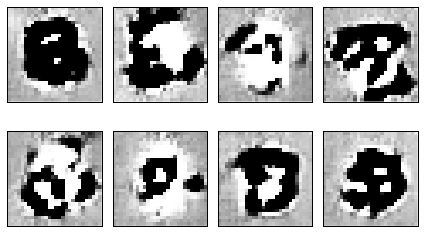

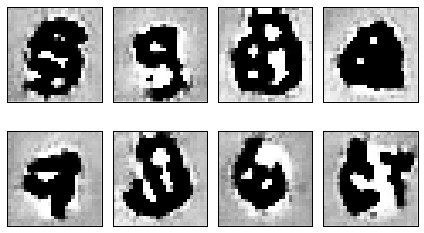

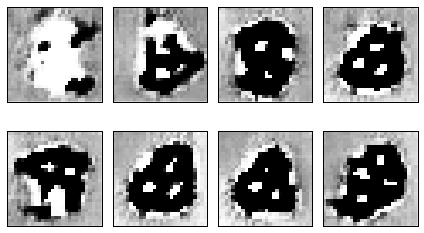

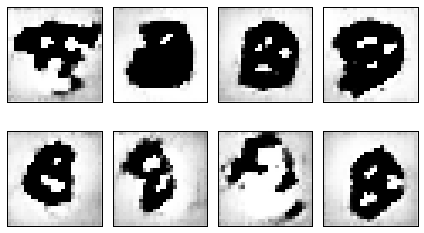

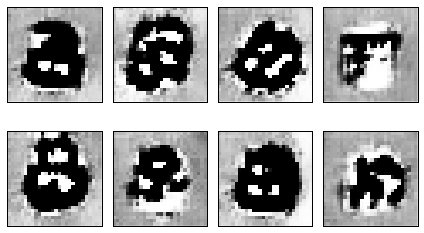

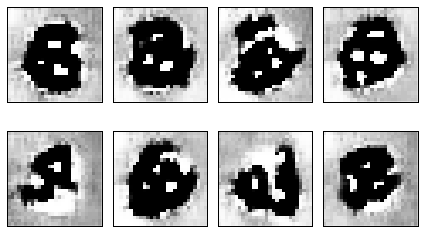

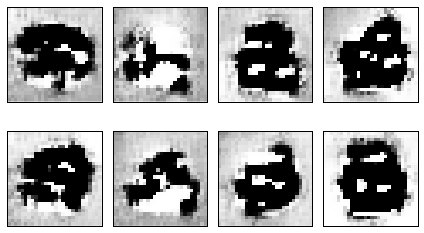

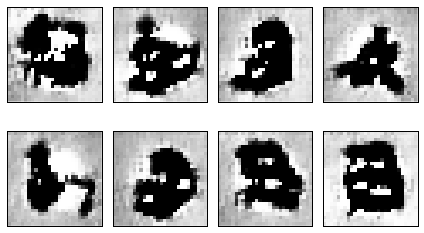

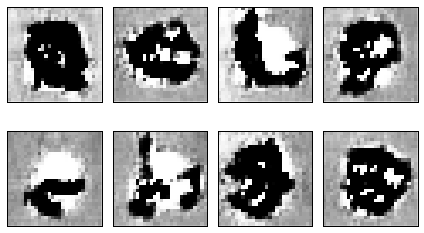

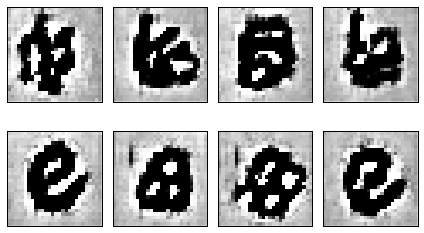

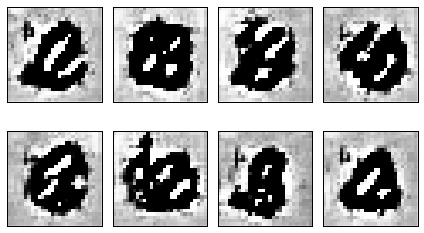

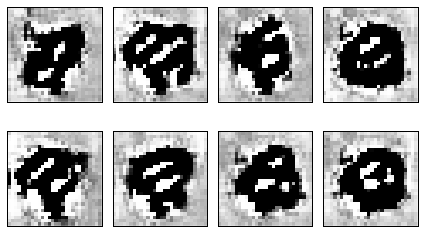

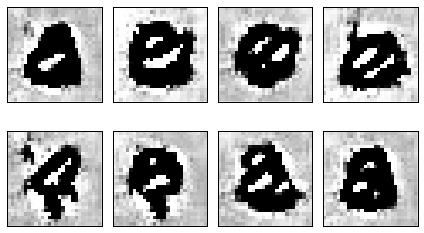

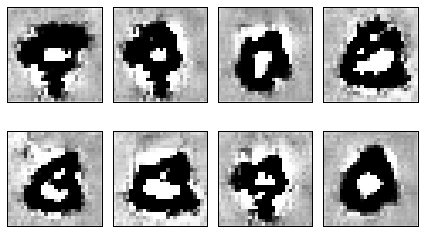

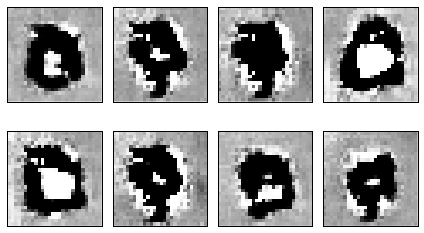

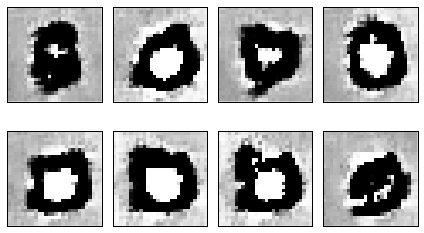

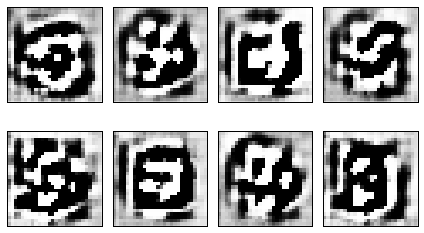

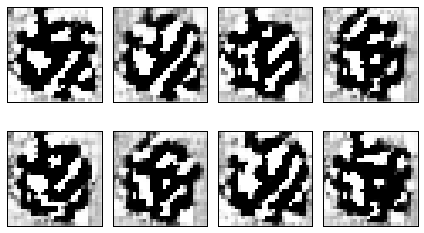

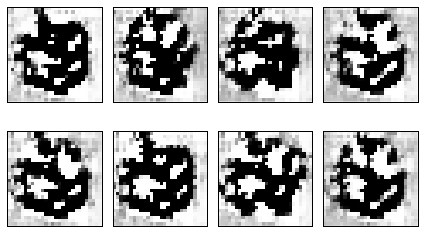

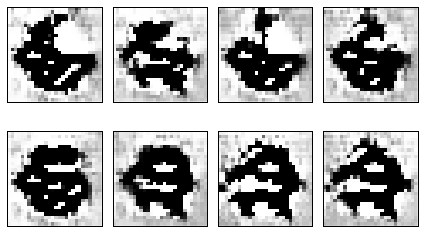

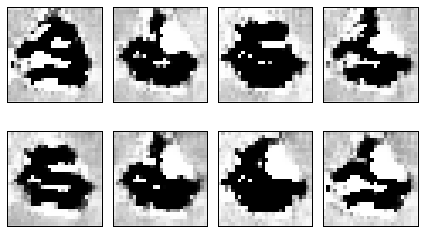

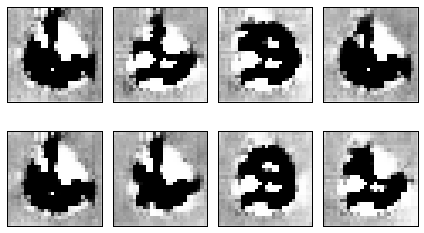

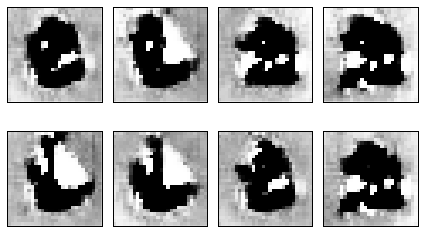

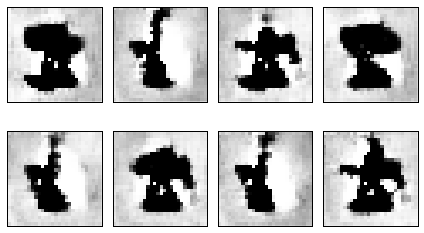

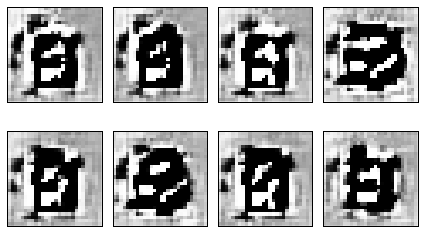

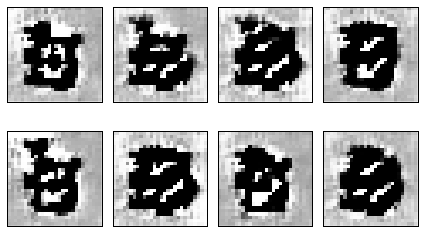

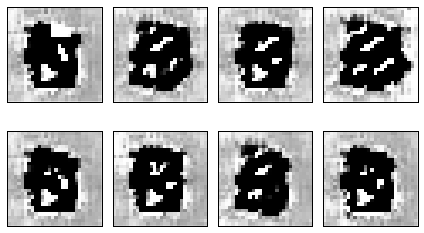

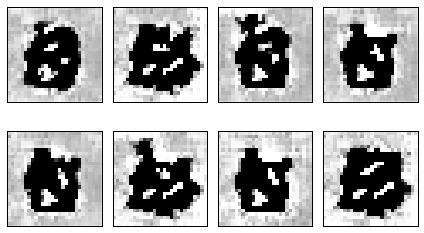

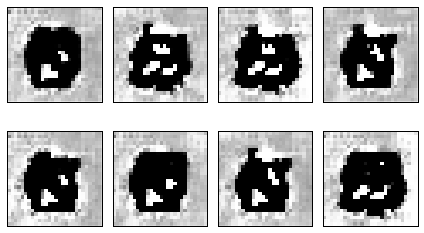

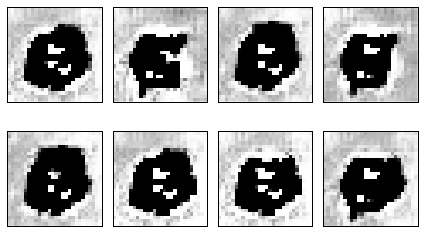

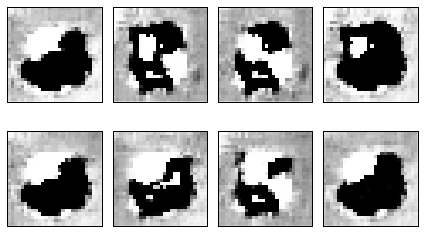

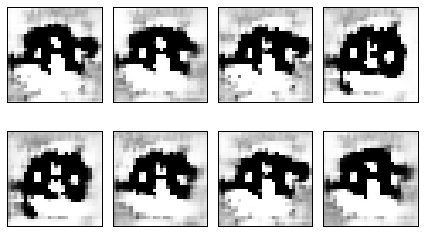

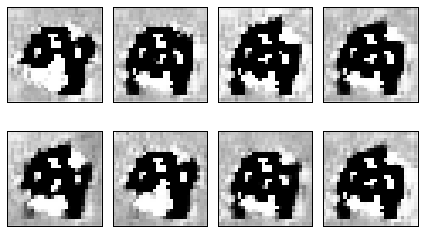

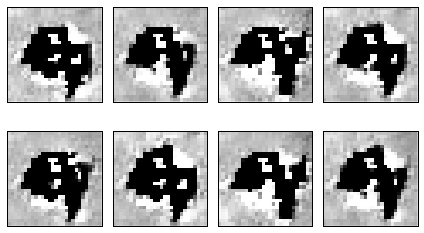

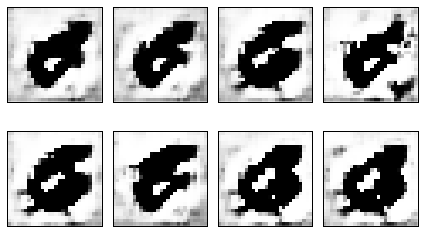

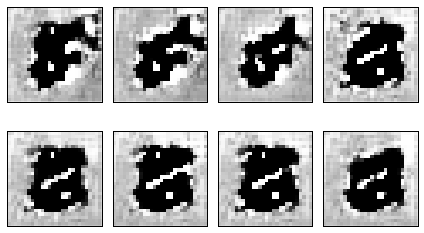

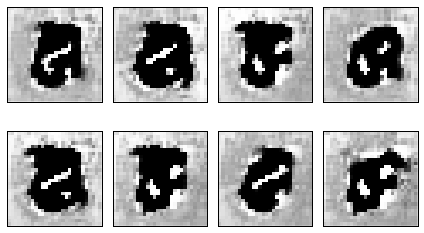

In [6]:
# setup experiment
max_epochs = 50
batch_size = 128
latent_dim = 100
z_space = get_gaussian_space(0, 1, latent_dim)
generator, discriminator, gen_dis = get_mlp_model(data_dim, latent_dim)

# prepare data
dis_labels = np.ones(2*batch_size) * 0.9# np.random.uniform(0.85, 1.0, 2*batch_size)
dis_labels[:batch_size] = 0 
gan_labels = np.ones(batch_size)

g_losses = []
d_losses = []

for epoch_ix in xrange(max_epochs):
    for batch_ix in tqdm(xrange(0, data_count-batch_size, batch_size)):
        # train discriminator - true
        discriminator.trainable = True
        x_samples = data_proc[batch_ix: batch_ix+batch_size].reshape(batch_size, -1)
        
        #print x_samples.shape
        
        x_samples = x_samples.reshape(128,28,28,1)
        
        d_loss_t = discriminator.train_on_batch(
            x_samples, dis_labels[batch_size:])
        
        # train discriminator - fake
        z_samples = z_space(batch_size).astype('float32')
        d_loss_f = discriminator.train_on_batch(
            generator.predict(z_samples), dis_labels[:batch_size])
        
        d_loss = (d_loss_t + d_loss_f) / 2

        # train generator
        z_samples = z_space(batch_size).astype('float32')
        discriminator.trainable = False
        g_loss = gen_dis.train_on_batch(z_samples, gan_labels)

    g_losses.append(g_loss)
    d_losses.append(d_loss)
    
    print 'epoch: {} -- loss G: {} - D: {}'.format(epoch_ix, 
                                                   g_loss, 
                                                   d_loss)
    z_samples = z_space(batch_size).astype('float32')
    fakes = generator.predict(z_samples[:8,:])
    plot_images(fakes, data_size)

TypeError: plot_images() got an unexpected keyword argument 'to_file'

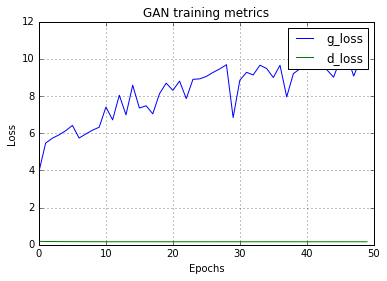

In [7]:
plot_performance(('g_loss', g_losses), ('d_loss', d_losses))

z_samples = z_space(batch_size).astype('float32')
fakes = generator.predict(z_samples[:8,:])
plot_images(fakes, data_size, to_file=True)